# Dataset statistics by class

## Libraries and methods

In [1]:
#libraries
from google.colab import drive
import pandas as pd
import numpy as np
#plots
import matplotlib.pyplot as plt
import seaborn as sns
#tokenization
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
#stopwords
nltk.download('stopwords') 
from nltk.corpus import stopwords
#lemmatization
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
#counter
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#method used to preprocess the dataset in order to plot it
#in particolar, it applies a particular order on one of a dataset label, select the features to be visualized and the number of rows

def get_df_for_plot(df, orderby, otherlabel, feature, df_name, index): 

  #ordering plot_df by the values of one label
  df = pd.concat([df.loc[df['label'] == orderby].sort_values(['value'], ascending=False).reset_index(drop=True), 
                        df.loc[df['label'] == otherlabel]], ignore_index=True)
  
  #selecting the features that need to be visualised together
  if pd.isna(col_names.loc[col_names["feature"]==feature, df_name][index]): 
    a = pd.DataFrame()
  else: 
    a = df.loc[df['feature'].isin(eval(col_names.loc[col_names["feature"]==feature, df_name][index]))]

    #selecting the first 10 rows (they all have the same label)
    first_rows = a.iloc[:10]

    #selecting the rows that has the same features as the first 10 (now we consider both labels)
    a = a.loc[a["feature"].isin(list(first_rows["feature"].values))]

  return a

In [3]:
#method used to plot the distributions of particular features

def feature_plot(df, feature, df_name): 
  plt.figure(figsize=(10,6))
  sns.set_theme(style="whitegrid")
  sns.barplot(x='feature', y="value", hue = 'label', data = df, palette=sns.color_palette("husl", 2), hue_order=["0", "1"])
  plt.xticks(rotation=30, ha="right")
  plt.title('Class distribution over a particular feature in dataset ' + df_name)
  plt.xlabel(feature)
  plt.ylabel("Frequency")
  plt.show()

In [4]:
def get_counter(series):
  flat_list = [item for sublist in series for item in sublist]
  c = Counter(flat_list) 
  return sorted(c.items(), key=lambda x: x[1], reverse=True)

In [5]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

In [6]:
def most_common_words(df): 

  #tokenization of text clean
  tokenized_text = []
  for i in df:
    tokenized_text.append(word_tokenize(i))
  tokenized_text = pd.Series(tokenized_text)

  #removal of stopwords
  stop = stopwords.words('english')
  tokenized_stop_text = tokenized_text.apply(lambda x: [item for item in x if item not in stop])

  #lemmatization
  tokenized_stop_text = tokenized_stop_text.apply(lemmatize_text)

  #removal of words with length == 1
  tokenized_stop_text = tokenized_stop_text.apply(lambda x: [item for item in x if(len(item) != 1)]) 
  
  #visualization of the first 50 most common words
  return get_counter(tokenized_stop_text)[:100]

In [7]:
def get_difference(x, y, simple=True): 

  #trasformation of x and y

  #from list of lists to list
  x = [item for sublist in x for item in sublist]
  #removing the counts
  x = [item for item in x if not isinstance(item, int)]
  #from list to set
  x = set(x)

  #from list of lists to list
  y = [item for sublist in y for item in sublist]
  #removing the counts
  y = [item for item in y if not isinstance(item, int)]
  #from list to set
  y = set(y)

  #difference between two sets
  if simple == True: #difference corresponds to the elements that are present in the first list but not in the second
    differences = x - y
  else: #difference corresponds to the elements that are not present in both lists
    differences = (x - y).union(y - x)
  
  return differences

## Import of data 
The imported data consists in: 
- `dataset["ace"]`: dataset obtained after a preprocessing step on the "ACE Inhibitors dataset" made in "Baseline Text Classification".
- `dataset["copd"]`: dataset obtained after a preprocessing step on the "COPD dataset" made in "Baseline Text Classification".
- `dataset["ppi"]`: dataset obtained after a preprocessing step on the "Proton Pump Inhibitors dataset" made in "Baseline Text Classification".
- `col_names`: a dataset obtained saving features names in "Baseline Text Classification".

In [8]:
#import of the processed dataset and the columns' names
from_drive = True
dataset = dict()
path = "/content/gdrive/MyDrive/Magistrale/Stage"

if from_drive == True: 
  drive.mount("/content/gdrive")
  dataset["ace"] = pd.read_csv(path + "/preprocessed_ace.csv")
  dataset["copd"] = pd.read_csv(path + "/preprocessed_copd.csv")
  dataset["ppi"] = pd.read_csv(path + "/preprocessed_ppi.csv")
  col_names = pd.read_csv(path + "/columns_names.csv")
else: 
  dataset["ace"] = pd.read_csv(path + "/content/preprocessed_ace.csv")
  dataset["copd"] = pd.read_csv(path + "/content/preprocessed_copd.csv")
  dataset["ppi"] = pd.read_csv(path + "/content/preprocessed_ppi.csv")
  col_names = pd.read_csv('/content/columns_names.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Dataset with statistics by class

In [9]:
data = pd.DataFrame() #dataset with the statistics by class
plot_df = dict() #dataset rearranged for plots

for i in dataset: 

  df = {k:None for k in ["0", "1"]}

  for j in df: #crete two differente df for each label

    df[j] = dataset[i].loc[dataset[i]["Label"] == int(j), ~dataset[i].columns.isin(["Unnamed: 0", "text", "text_clean"])] #removing index, text, text_clean
    df[j] = pd.DataFrame(df[j].sum(axis=0).astype(int)).T
    #normalization of frequency counts
    df[j] = df[j]/ len(dataset[i][dataset[i]["Label"] == int(j)])
    df[j]["Dataset"] = i

    data = pd.concat([data, df[j]], ignore_index = True) #adding each df in the final data dataset with the statistics by class

    #rearrenge the dataset in order to plot it -> creation of plot_df
    
    df[j] = df[j].T
    df[j]["feature"] = df[j].index
    df[j]["label"] = j

  plot_df[i] = pd.concat([df["0"], df["1"]], axis=0)
  plot_df[i].rename(columns={0 : "value"}, inplace=True)
  plot_df[i] = plot_df[i].reset_index(drop=True)
  plot_df[i] = plot_df[i].loc[plot_df[i]["feature"] != "Dataset"]

In [10]:
data

,Label,Clinical Trial,Controlled Clinical Trial,Journal Article,"Research Support, Non-U.S. Gov't",Randomized Controlled Trial,"Research Support, U.S. Gov't, P.H.S.",Review,Comparative Study,Multicenter Study,...,journal_title_abbreviation_Surgery,journal_title_abbreviation_Ther Drug Monit,journal_title_abbreviation_Transpl Int,journal_title_abbreviation_Trop Gastroenterol,journal_title_abbreviation_Ulster Med J,journal_title_abbreviation_World J Gastroenterol,journal_title_abbreviation_World J Surg,journal_title_abbreviation_Z Gastroenterol,journal_title_abbreviation_Zhonghua Min Guo Xiao Er Ke Yi Xue Hui Za Zhi,journal_title_abbreviation_Zhonghua Yi Xue Za Zhi (Taipei)
0,0.0,0.655958,0.064254,0.947540,0.394469,0.546970,0.050020,0.157381,0.308662,0.196421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.864865,0.000000,1.000000,0.567568,0.864865,0.027027,0.000000,0.405405,0.486486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.568966,0.037618,0.957680,0.367555,0.418495,0.014107,0.221003,0.277429,0.161442,...,0.000784,0.000784,0.000784,0.000784,0.000784,0.00627,0.000784,0.003918,0.000784,0.000784
5,1.0,0.862745,0.019608,0.980392,0.647059,0.823529,0.039216,0.019608,0.745098,0.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


The normalization of the absolute frequencies was made dividing the value of each observation by the total number of observations with the same label as the considered one.
- 0: the frequency for that class was zero.
- 1: the frequency for that class was equal to the number of obeservation for that class (every obeservation of that class presented that feature).

In [11]:
col_names

,Unnamed: 0,feature,ace,ppi,copd
0,0,publication_type,"['Clinical Trial', 'Controlled Clinical Trial'...","['Clinical Trial', 'Comparative Study', 'Journ...",NaN
1,1,full_authors,"['Nazzaro, P', 'Manzari, M', 'Merlo, M', 'Trig...","['Bardhan, K D', 'Muller-Lissner, S', 'Bigard,...",NaN
2,2,['contains_topic'],['contains_topic'],['contains_topic'],['contains_topic']
3,3,['contains_other_topic'],['contains_other_topic'],['contains_other_topic'],['contains_other_topic']
4,4,publication_date,"['publication_date_1988 May', 'publication_dat...","['publication_date_1992', 'publication_date_19...",NaN
5,5,publication_place,"['publication_place_Argentina', 'publication_p...","['publication_place_Argentina', 'publication_p...",NaN
6,6,journal_title_abbreviation,"['journal_title_abbreviation_Acad Emerg Med', ...",['journal_title_abbreviation_AJR Am J Roentgen...,NaN


## Distribution plots

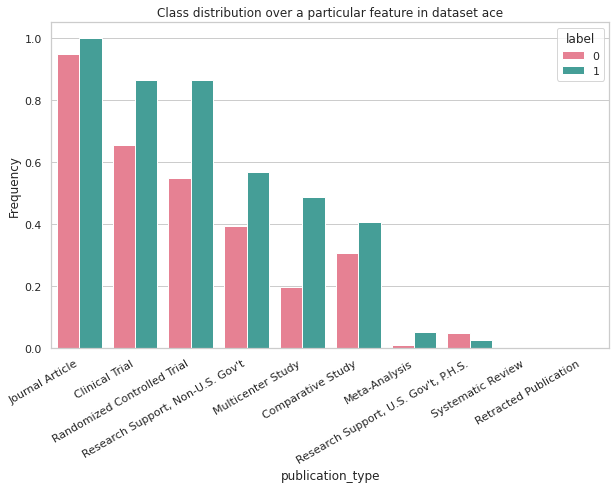

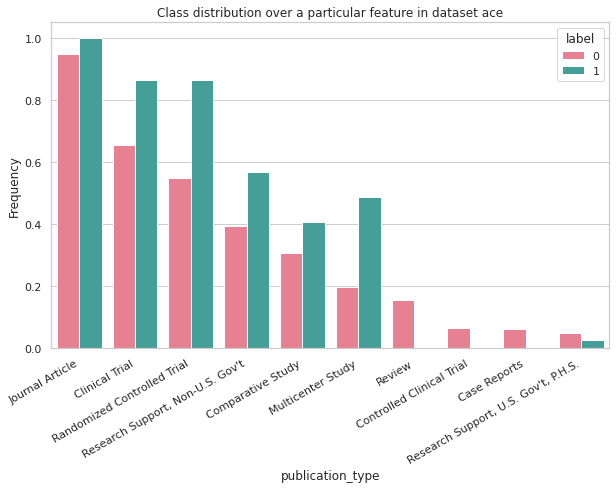

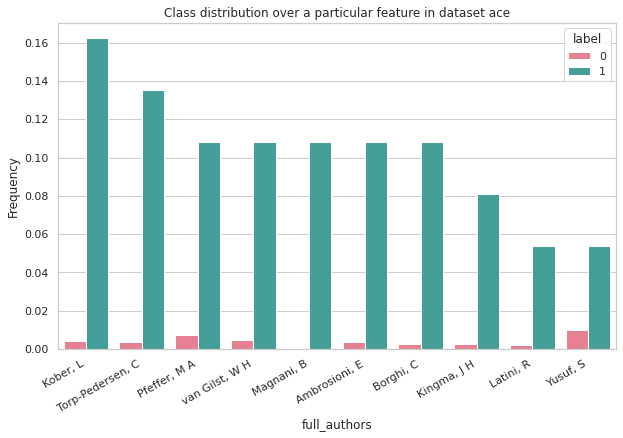

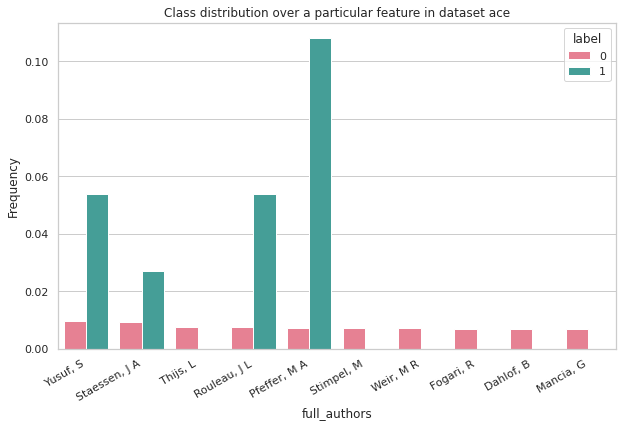

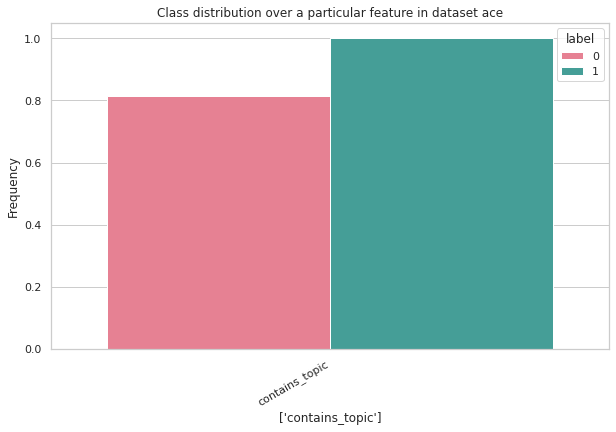

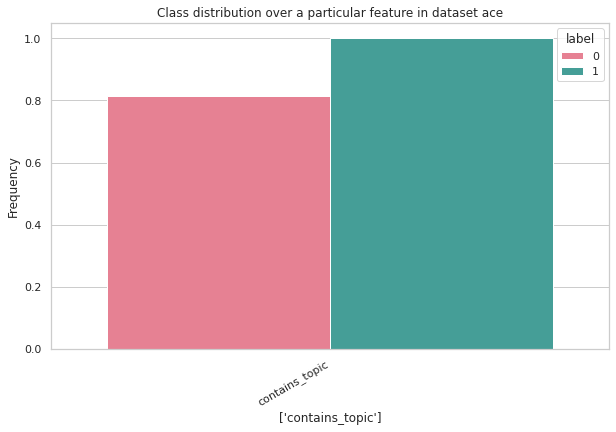

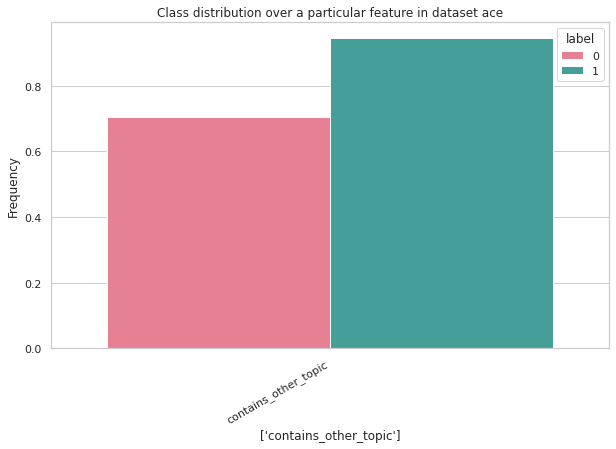

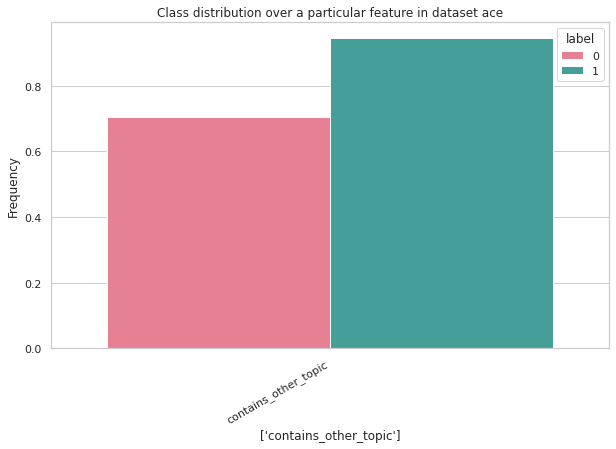

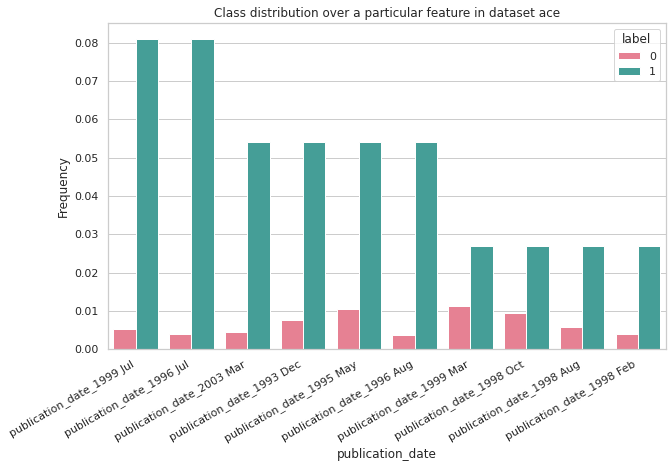

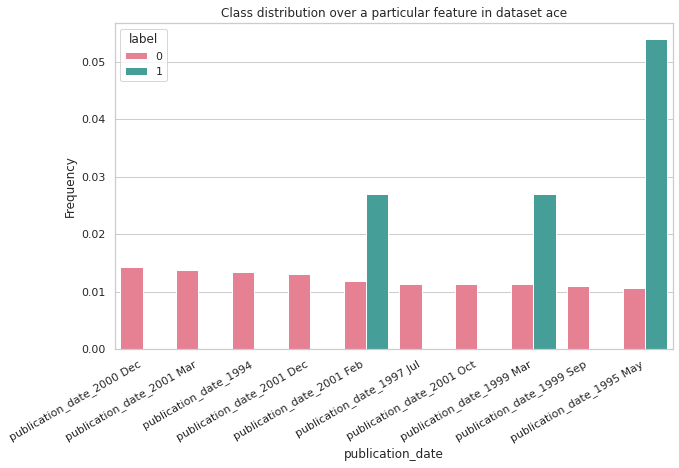

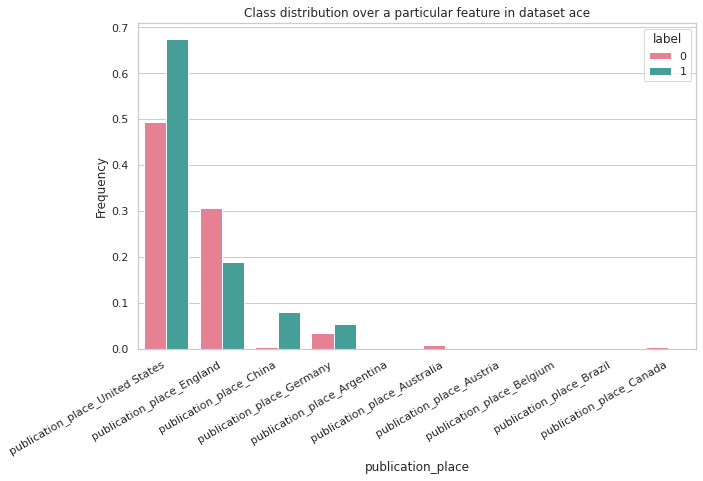

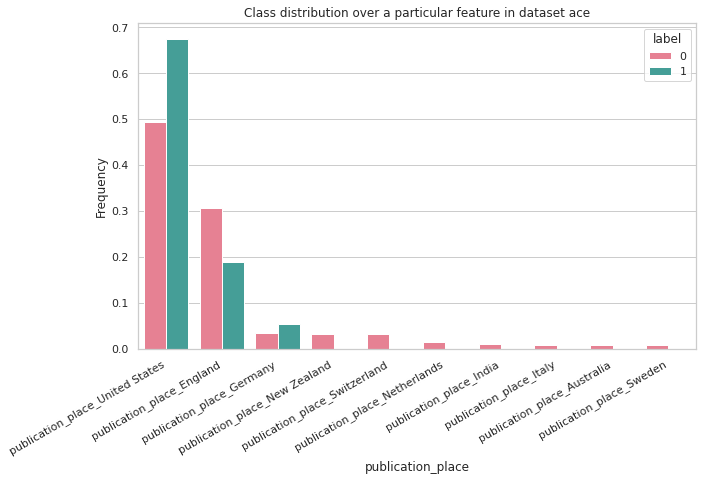

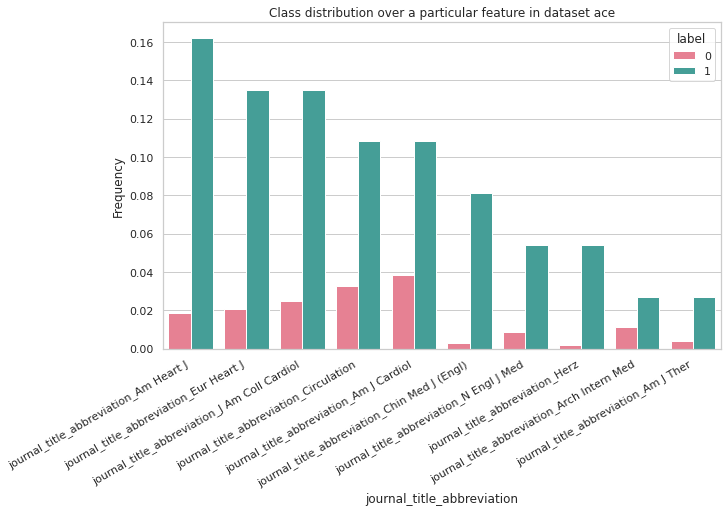

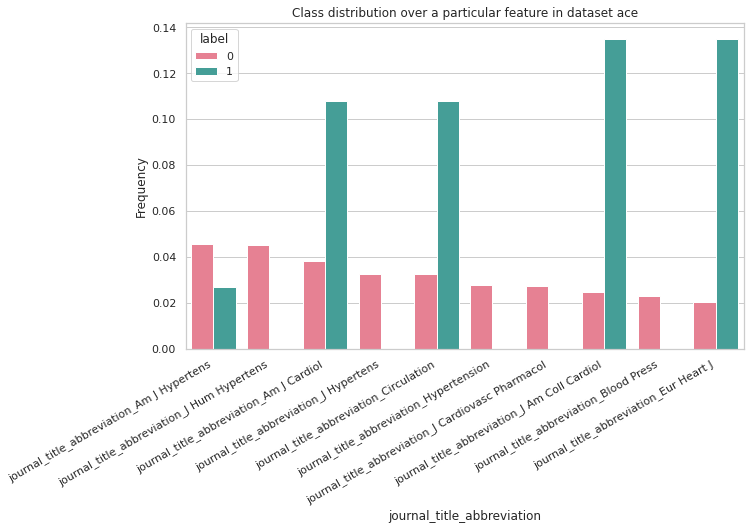

Feature not present: publication_type
Feature not present: publication_type
Feature not present: full_authors
Feature not present: full_authors


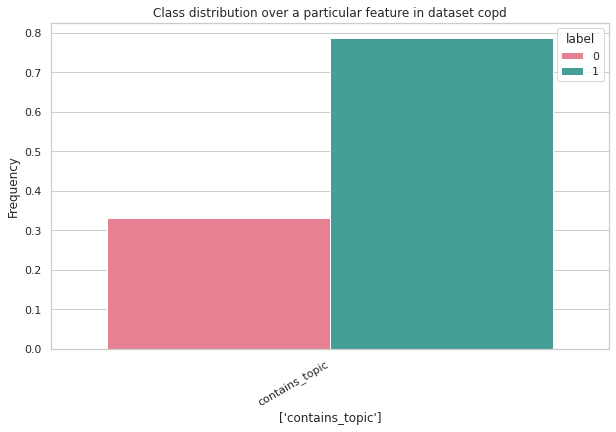

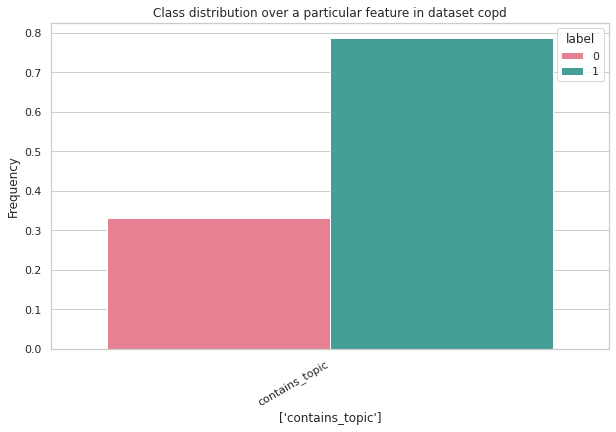

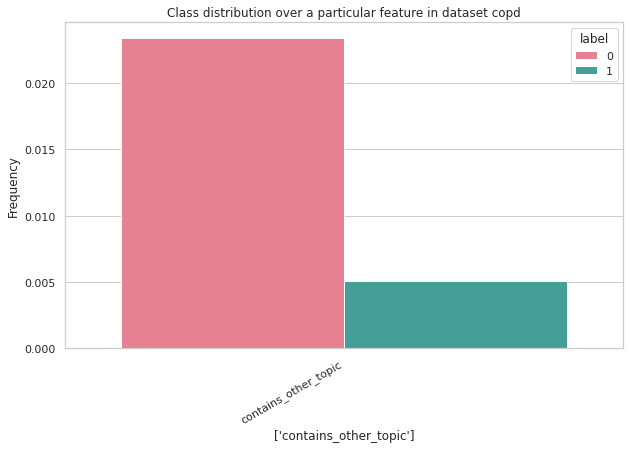

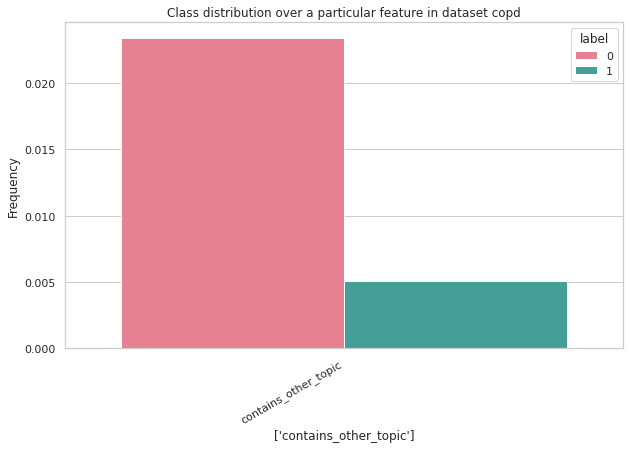

Feature not present: publication_date
Feature not present: publication_date
Feature not present: publication_place
Feature not present: publication_place
Feature not present: journal_title_abbreviation
Feature not present: journal_title_abbreviation


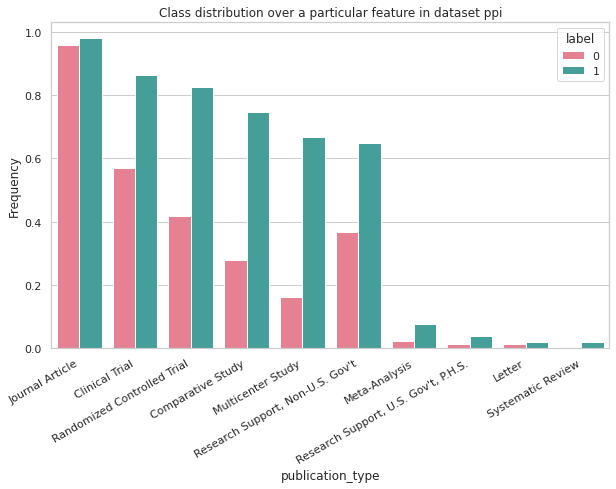

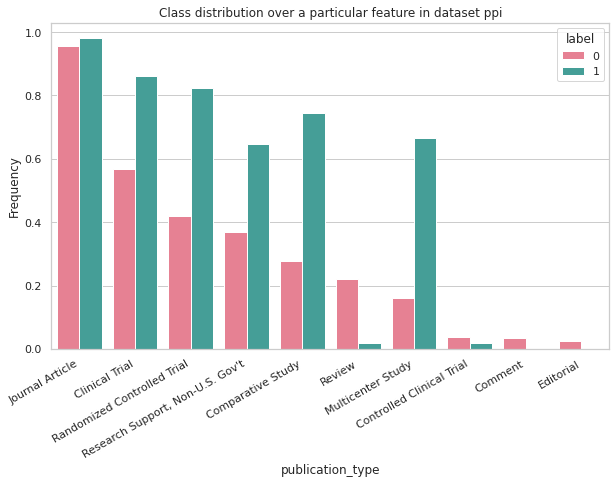

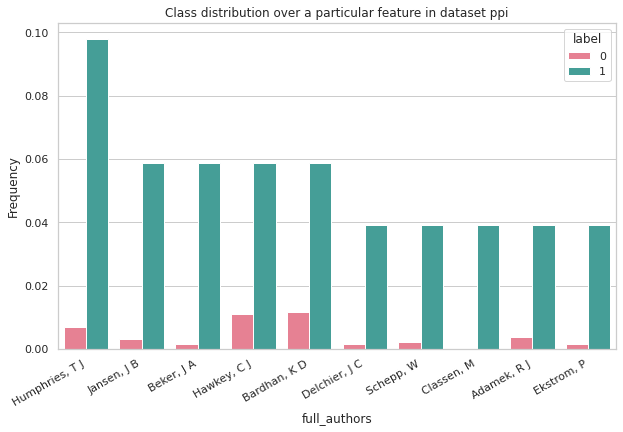

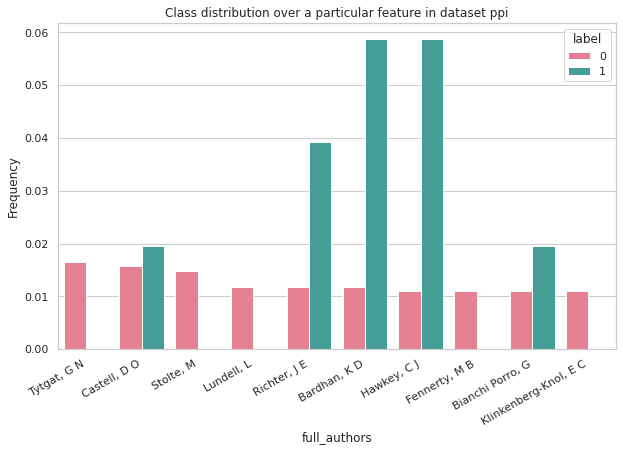

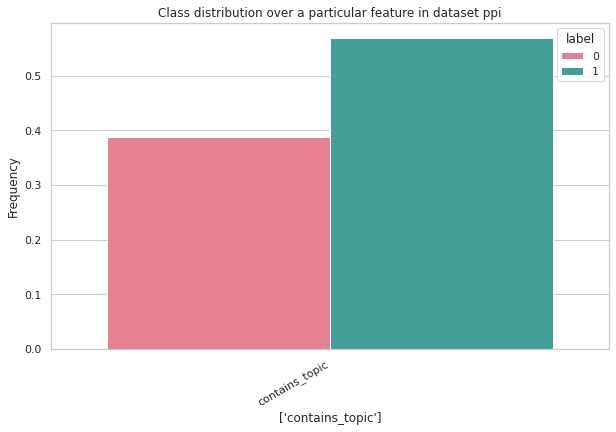

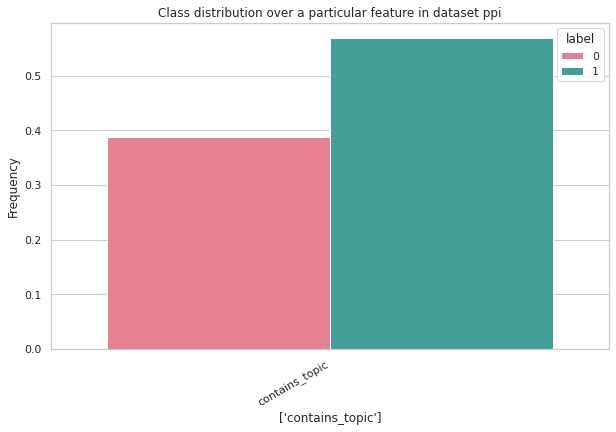

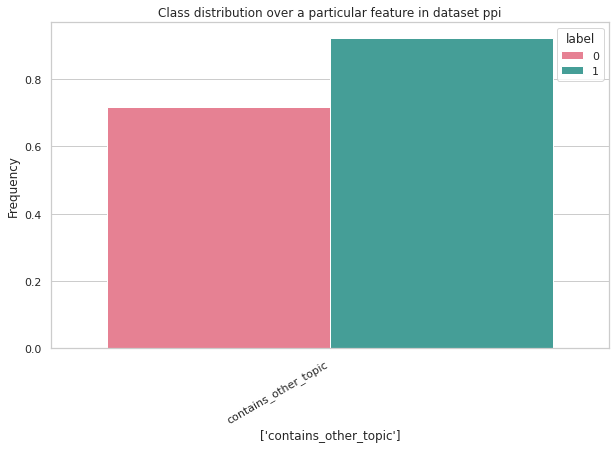

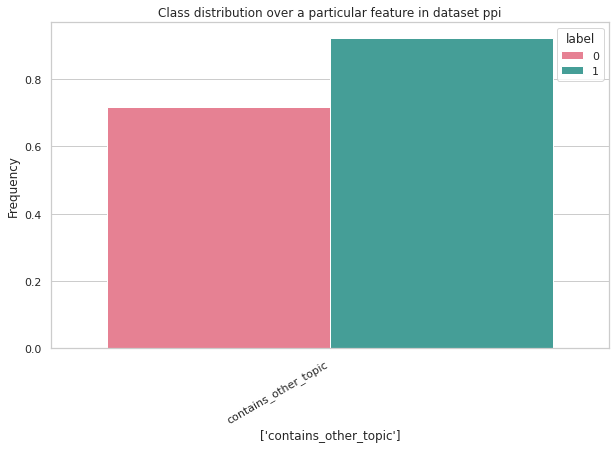

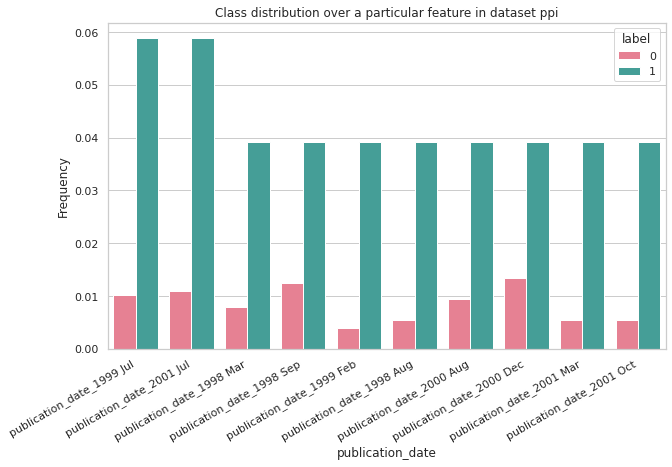

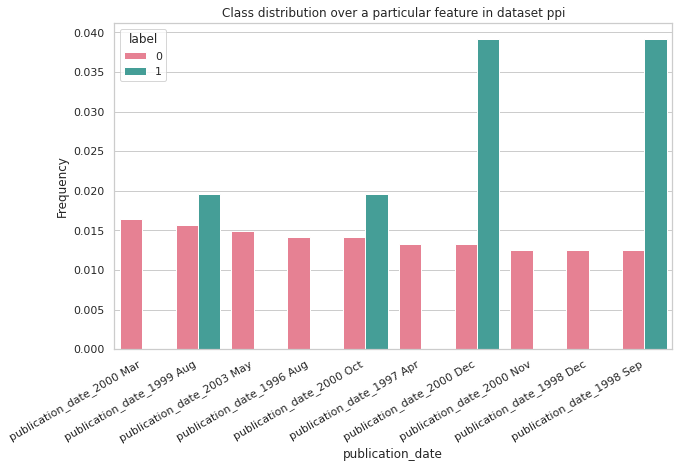

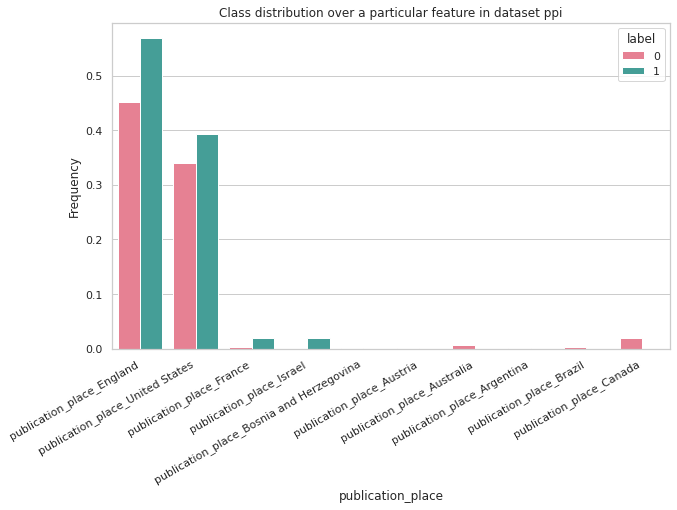

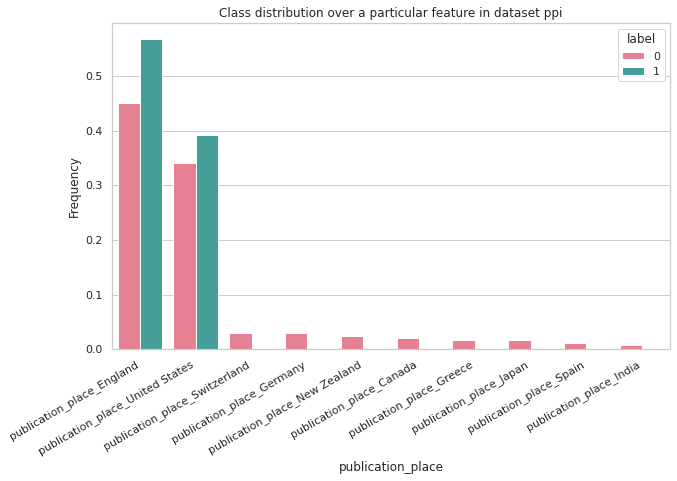

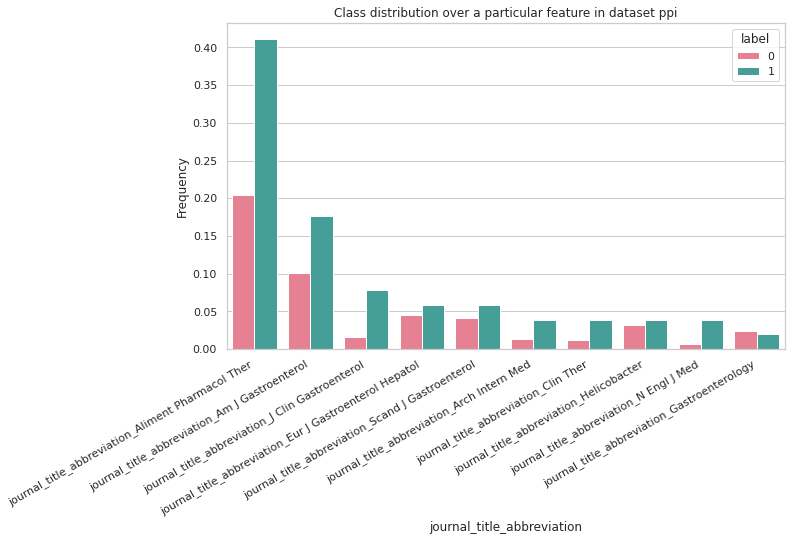

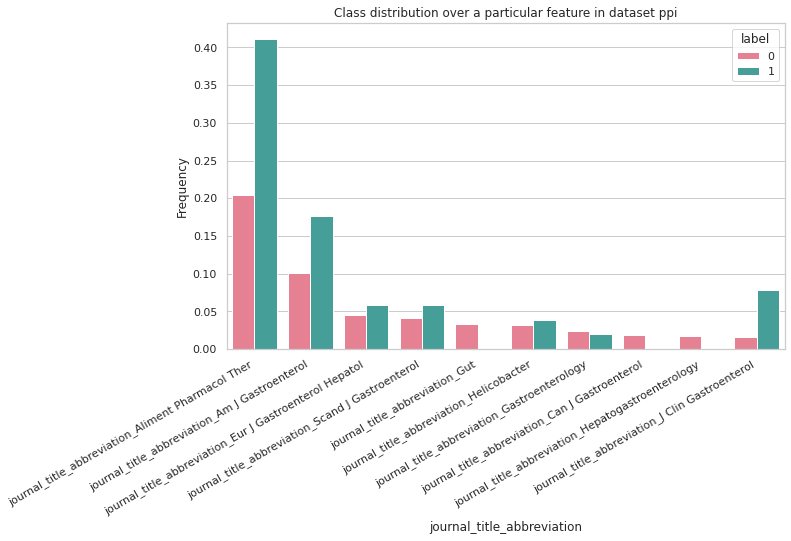

In [12]:
for i in plot_df: 

  #plotting class distribution over every group of features
  for index, j in enumerate(col_names["feature"]): 

    #ordering by label 1
    a = get_df_for_plot(df=plot_df[i], orderby="1", otherlabel="0", feature=j, df_name=i, index=index)

    if a.empty: 
      print("Feature not present:", j)
    else: 
      feature_plot(a, j, i)

    #ordering by label 0
    a = get_df_for_plot(df=plot_df[i], orderby="0", otherlabel="1", feature=j, df_name=i, index=index)

    if a.empty: 
      print("Feature not present:", j)
    else: 
      feature_plot(a, j, i)

## Most frequent words

In [13]:
#computing the most frequent words for each dataset and for each label's value
for i in dataset: 
  total_most_common_words = most_common_words(dataset[i]["text_clean"])
  zero_most_common_words = most_common_words(dataset[i].loc[dataset[i]["Label"]==0, "text_clean"])
  one_most_common_words = most_common_words(dataset[i].loc[dataset[i]["Label"]==1, "text_clean"])

  print("Dataset", i)
  print("Most common words that have label 1 but not 0:")
  print(get_difference(one_most_common_words, zero_most_common_words, simple=True))
  print("Most common words that have label 0 but not 1:")
  print(get_difference(zero_most_common_words, one_most_common_words, simple=True), "\n")

Dataset ace
Most common words that have label 1 but not 0:
{'controlled', 'anterior', 'inhibition', 'data', 'ci', 'first', 'percent', 'incidence', 'fosinopril', 'event', 'hour', 'trandolapril', 'confidence', 'interval', 'volume', 'fraction', 'term', 'end', 'ami', '001', 'long', 'reduced', 'acute', 'mi', 'benefit', 'cardiac', 'within', 'lv', '95', 'ejection', 'early', 'severe', 'life', 'death', 'follow', 'time', 'survival', 'dysfunction'}
Most common words that have label 0 but not 1:
{'receptor', 'bp', 'combination', 'agent', 'compared', 'diastolic', 'hypertensive', 'pharmacology', 'change', 'type', 'dose', 'hypertension', 'losartan', 'daily', 'period', 'mean', 'may', 'diabetes', 'factor', 'adult', 'hg', 'complication', 'treated', 'blocker', 'ii', '20', 'induced', 'lisinopril', 'response', 'disease', 'plasma', 'level', 'antihypertensive', '10', 'mm', 'renal', 'increased', 'antagonist'} 

Dataset copd
Most common words that have label 1 but not 0:
{'hla', 'decline', 'tnf', 'healthy', 'c